# Longitudinal profile of 3D clusters
## Interval of layers holding fraction of 3D cluster energy : length of interval

In [1]:
import sys
from dataclasses import dataclass
import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import mplhep as hep
plt.style.use(hep.style.CMS)
import hist

sys.path.append("..")
from HistogramLib.histogram import HistogramKind
from HistogramLib.store import HistogramStore
from hists.parameters import beamEnergies
from hists.store import HistogramId

In [2]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v41'
#clueParams = "single-file"
clueParams = "cmssw"
histStore = HistogramStore(hist_folder, HistogramId)
datatypeToLegendMap = {"data":"Data"}

In [3]:
@dataclass
class PlotInfo:
    beamEnergy:int|None
    datatype:str
    histName:str = "Clus3DIntervalHoldingFractionOfEnergy_IntervalLength"
    projectOn:str = None
    intervalEnergyFraction:str|list[str]|None = None
    maskLayer:str = "no"
    

In [4]:
def getHist(info:PlotInfo) -> hist.Hist:
    projections = {
        "mainOrAllTracksters" : hist.loc("mainTrackster"),
        # Project on clus3D_size
        "maskLayer" : info.maskLayer
    }
    if info.beamEnergy is not None:
        projections["beamEnergy"] = hist.loc(info.beamEnergy)
    if info.intervalEnergyFraction is not None:
        projections["intervalEnergyFraction"] = hist.loc(info.intervalEnergyFraction)
    return (histStore
        .get(HistogramId(info.histName, clueParams, info.datatype))
        .getHistogram(HistogramKind.COUNT)[projections]
        .project(info.projectOn)
    )

In [5]:
getHist(PlotInfo(datatype="data", beamEnergy=20, intervalEnergyFraction="0.9", projectOn="intervalFractionEnergy_length"))

Hist(Integer(0, 30, name='intervalFractionEnergy_length', label='Number of layers of smallest interval holding at least fraction of 3D cluster energy'), storage=Double()) # Sum: 19433.0

## Distribution of length of layer holding fraction of energy

In [6]:
def makeLengthOfLayerDistribution(plotInfo:PlotInfo):
    """ Plot distribution of length of layers holding fraction of 3D clustered energy, for different fractions"""
    if plotInfo.projectOn is None:
        plotInfo.projectOn = "intervalFractionEnergy_length"
    if type(plotInfo.intervalEnergyFraction) is list:
        h = []
        labels = []
        for fraction in plotInfo.intervalEnergyFraction:
            individualPlotInfo = copy.copy(plotInfo)
            individualPlotInfo.intervalEnergyFraction = fraction
            h.append(getHist(individualPlotInfo))
            labels.append(f"{float(fraction):.0%} of cluster energy")
    elif type(plotInfo.datatype) is list:
        h = []
        labels = []
        for datatype in plotInfo.datatype:
            individualPlotInfo = copy.copy(plotInfo)
            individualPlotInfo.datatype = datatype
            newHist = getHist(individualPlotInfo)
            if len(h) > 0:
                h.append(newHist * (h[0].sum(flow=False) /newHist.sum(flow=False)))
            else:
                h.append(newHist)
            labels.append(datatype)
    else:
        h = getHist(plotInfo)
        labels = None

    plt.figure()
    plt.xlabel("Layer length")
    plt.ylabel("Event count")
    
    hep.histplot(h, yerr=False, label=labels)

    plt.xlim(0, 20)
    if plotInfo.datatype == "data":
        hep.cms.text("Preliminary")
    else:
        hep.cms.text("Simulation Preliminary")
    hep.cms.lumitext("$e^+$ " + str(plotInfo.beamEnergy) + " GeV")
    plt.legend()

### With different fractions of energy

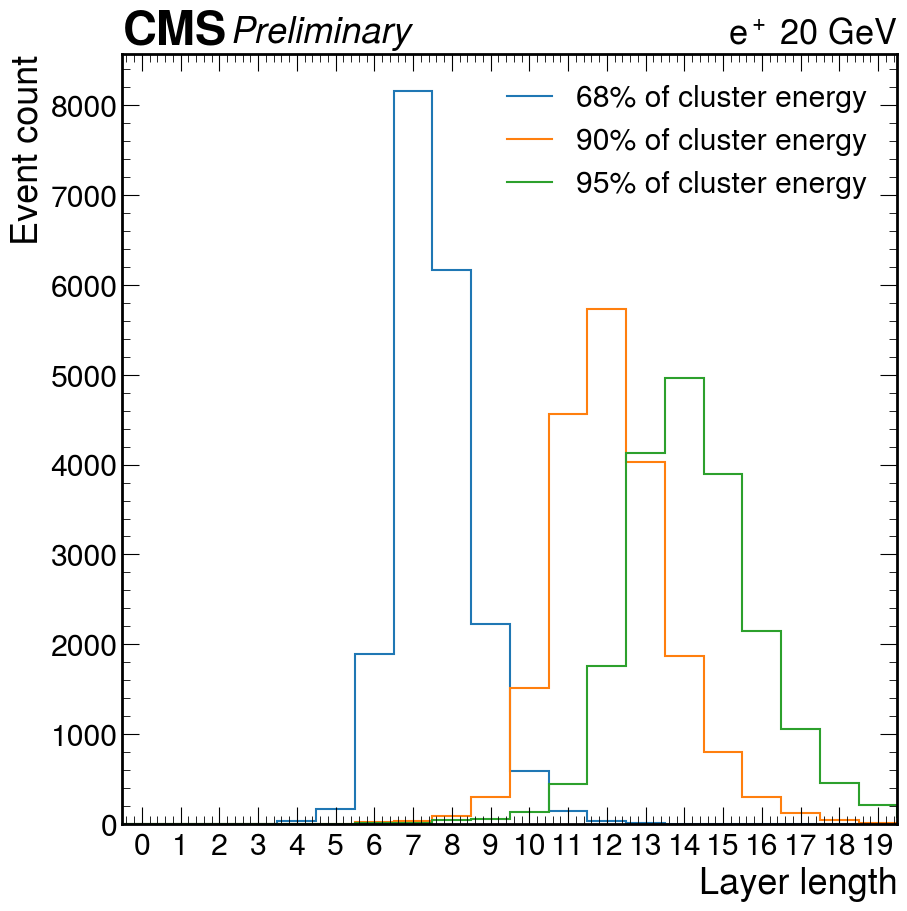

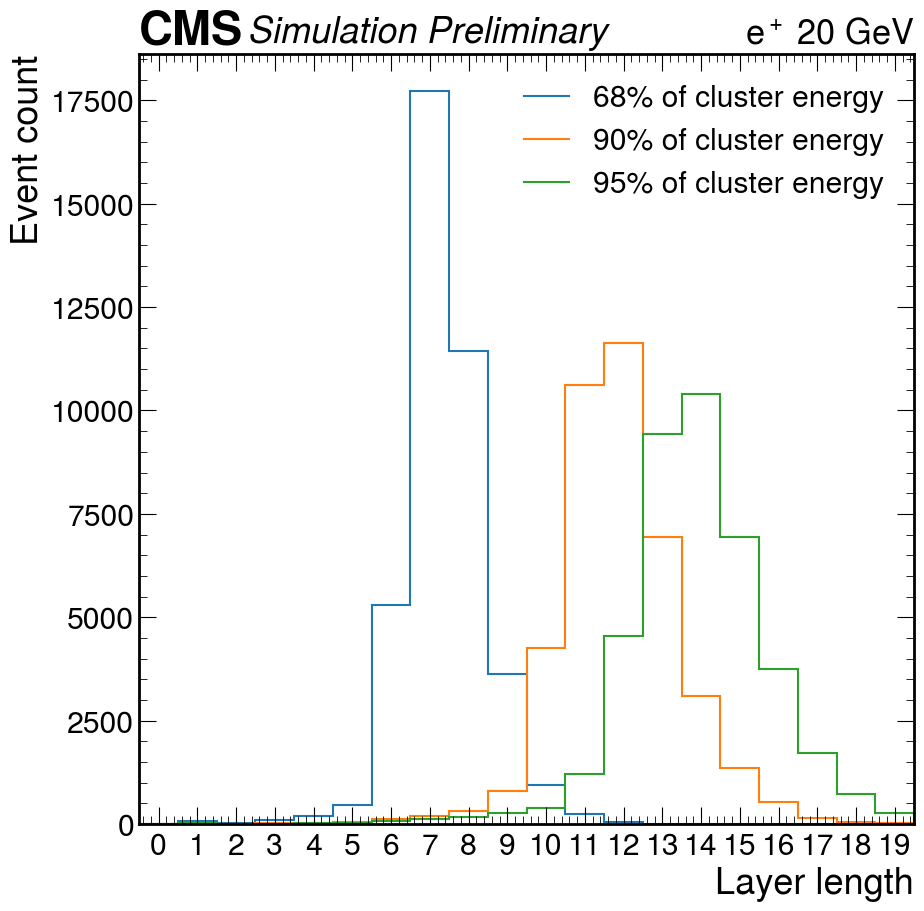

In [7]:
makeLengthOfLayerDistribution(PlotInfo(beamEnergy=20, datatype="data", intervalEnergyFraction=["0.68", "0.9", "0.95"]))
makeLengthOfLayerDistribution(PlotInfo(beamEnergy=20, datatype="sim_proton_v46_patchMIP", intervalEnergyFraction=["0.68", "0.9", "0.95"]))

### Data/simulation
Simulation is normalized to data counts

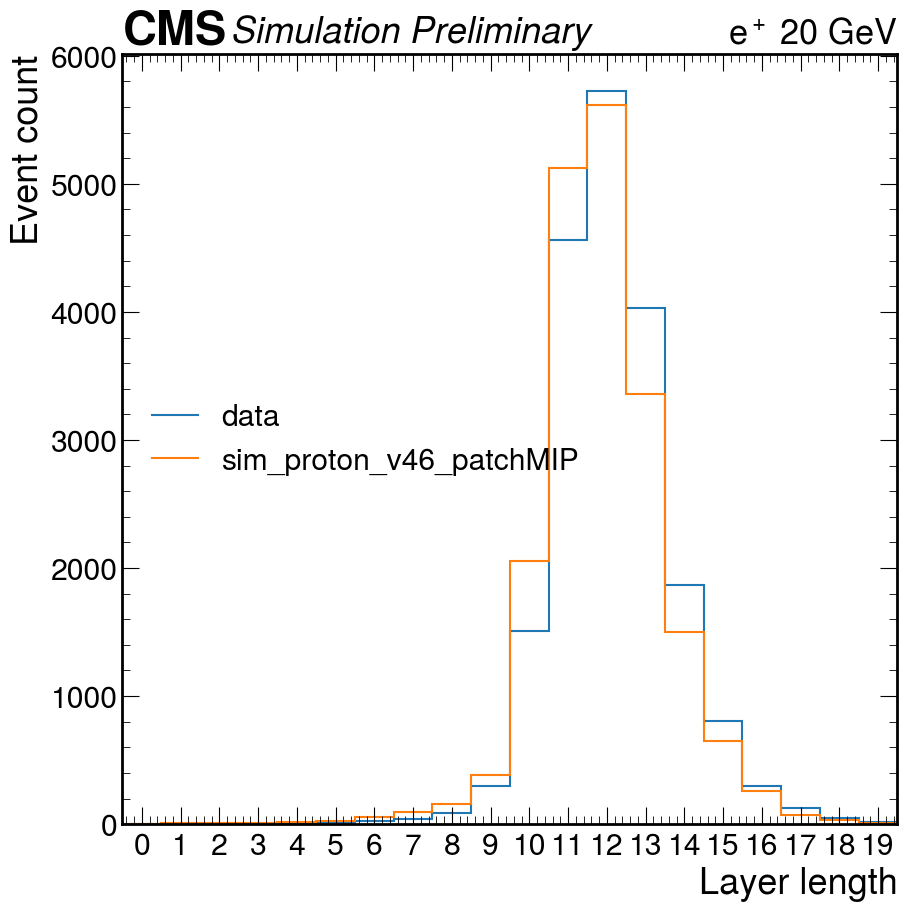

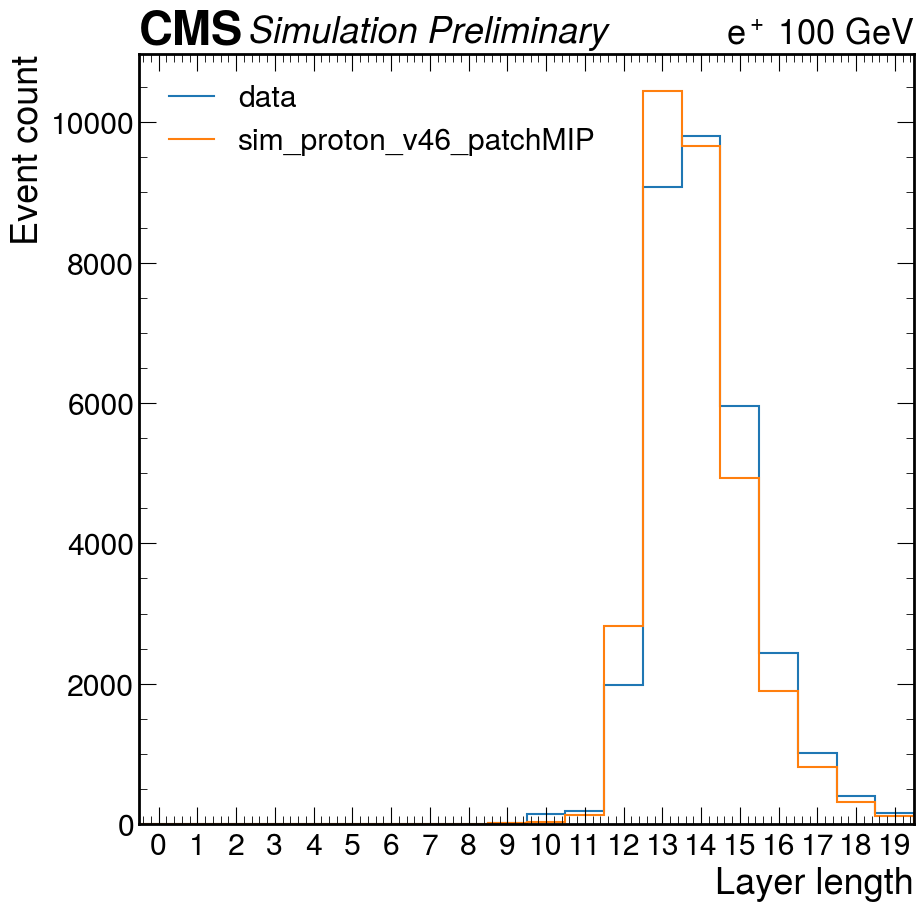

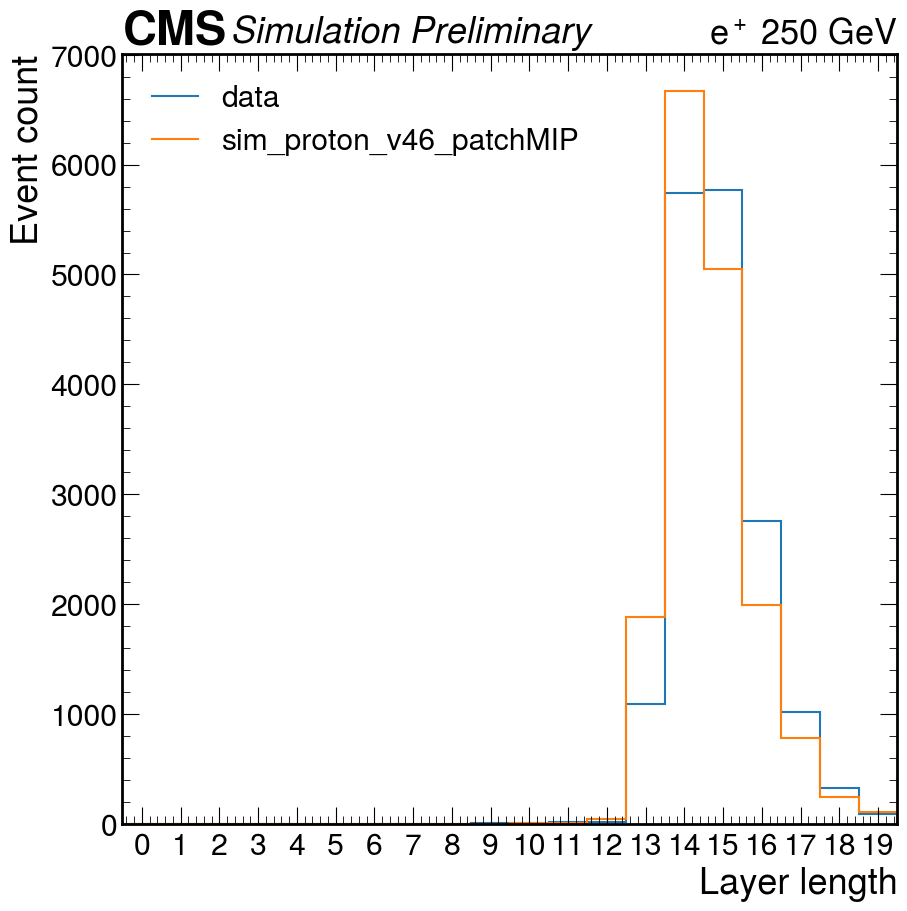

In [8]:
makeLengthOfLayerDistribution(PlotInfo(beamEnergy=20, datatype=["data", "sim_proton_v46_patchMIP"], intervalEnergyFraction="0.9"))
makeLengthOfLayerDistribution(PlotInfo(beamEnergy=100, datatype=["data", "sim_proton_v46_patchMIP"], intervalEnergyFraction="0.9"))
makeLengthOfLayerDistribution(PlotInfo(beamEnergy=250, datatype=["data", "sim_proton_v46_patchMIP"], intervalEnergyFraction="0.9"))

### Data/sim, Masking layer 10

In [9]:
#makeLengthOfLayerDistribution(PlotInfo(beamEnergy=20, datatype=["data", "sim_proton_v46_patchMIP"], intervalEnergyFraction="0.9", maskLayer="maskLayer10"))
#makeLengthOfLayerDistribution(PlotInfo(beamEnergy=100, datatype=["data", "sim_proton_v46_patchMIP"], intervalEnergyFraction="0.9", maskLayer="maskLayer10"))
#makeLengthOfLayerDistribution(PlotInfo(beamEnergy=250, datatype=["data", "sim_proton_v46_patchMIP"], intervalEnergyFraction="0.9", maskLayer="maskLayer10"))

## Profile interval length, fct of beam energy

In [10]:
def makePlotProfile_fctBeamEnergy(intervalEnergyFraction:str, datatypes, maskLayer:str="no"):
    """ Plot mean of interval length holding fraction of energy, as a function of beam energy"""
    hists = [(histStore
        .get(HistogramId("Clus3DIntervalHoldingFractionOfEnergy_MeanIntervalLength", clueParams, datatype))
        .getHistogram(HistogramKind.PROFILE)[{
            "mainOrAllTracksters" : hist.loc("mainTrackster"),
            # Project on clus3D_size
            "intervalEnergyFraction" : hist.loc(intervalEnergyFraction),
            #"beamEnergy" : hist.loc(20),
            "maskLayer" : maskLayer,
        }]
        .project("beamEnergy")
        ) for datatype in datatypes]
    labels = [datatypeToLegendMap.get(datatype, datatype) for datatype in datatypes]
    
    plt.figure()
    plt.xlabel("Nominal beam energy (GeV)")
    plt.ylabel(f"Mean of number of layers of smallest interval\nholding at least {float(intervalEnergyFraction):.0%} of 3D cluster energy")
    
    hep.histplot(hists, yerr=False, label=labels, histtype="errorbar", linestyle="-")

    if "data" in datatypes:
        hep.cms.text("Preliminary")
    else:
        hep.cms.text("Simulation Preliminary")
    hep.cms.lumitext("$e^+$ beam")
    plt.legend()

### Interval holding 90% of energy of 3D cluster

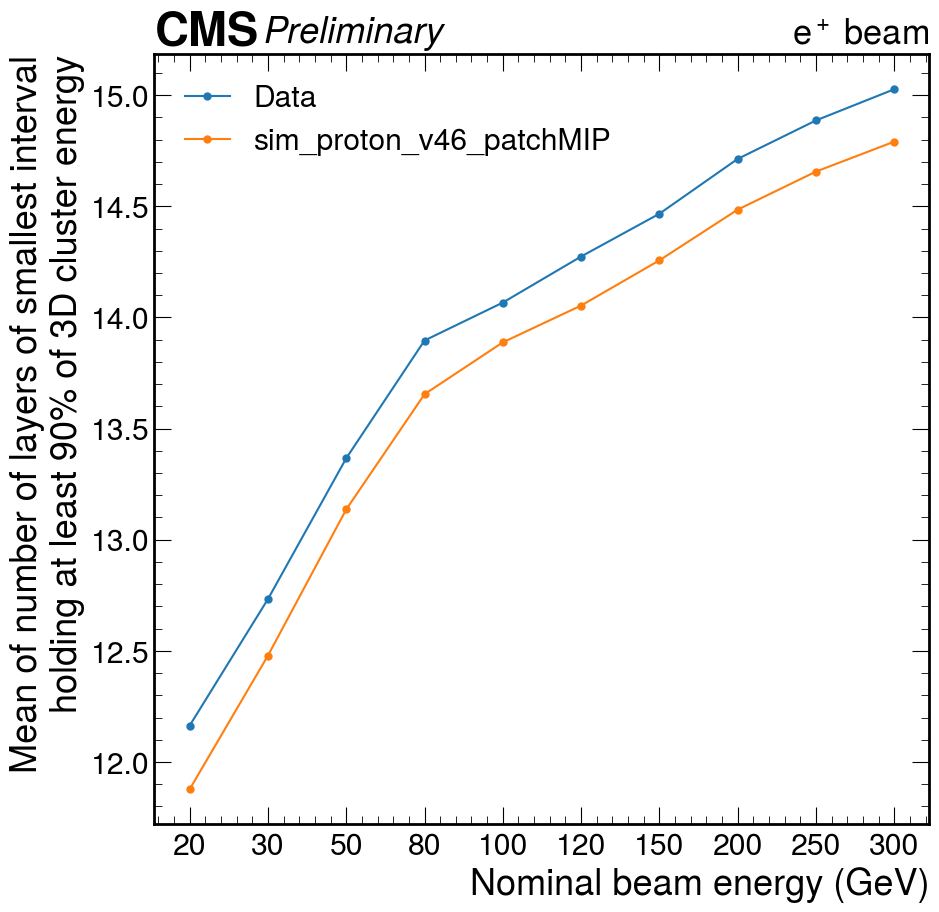

In [11]:
#["data", "sim_proton_v7", "sim_proton_v46_patchMIP", "sim_noproton_v6"]
makePlotProfile_fctBeamEnergy("0.9", ["data", "sim_proton_v46_patchMIP"])
#makePlotProfile_fctBeamEnergy("0.9", ["data", "sim_proton_v46_patchMIP"], maskLayer="maskLayer10")

### 68%

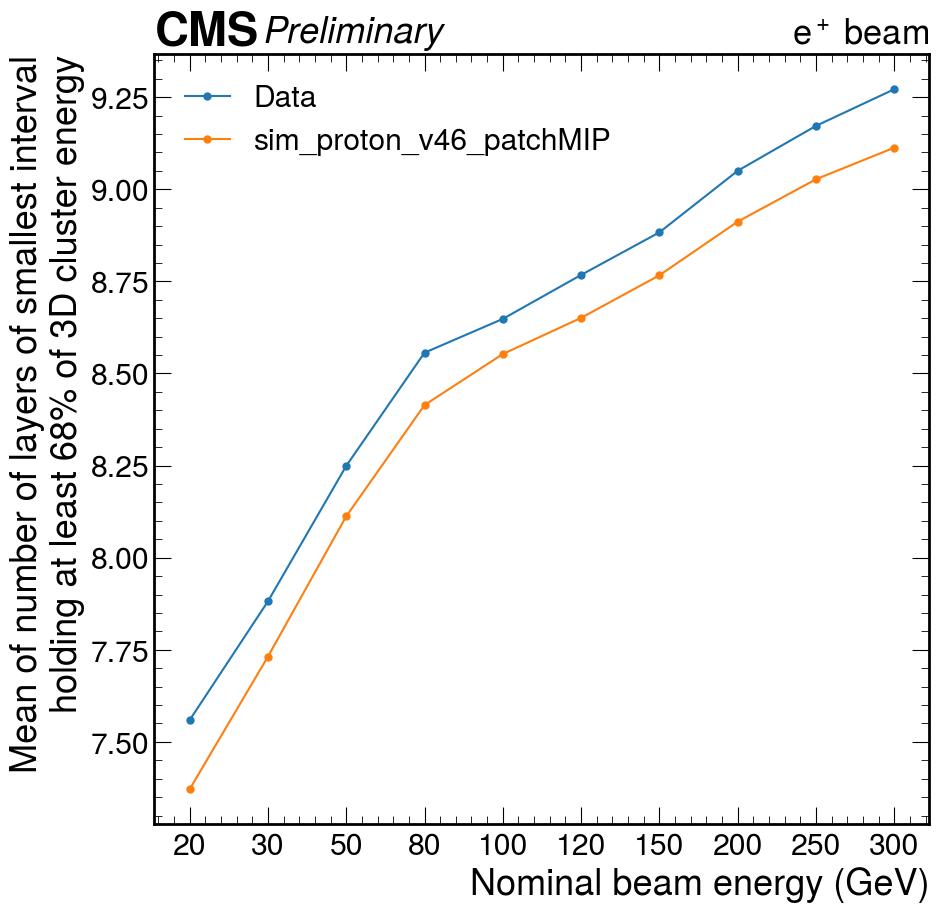

In [12]:
makePlotProfile_fctBeamEnergy("0.68", ["data", "sim_proton_v46_patchMIP"])
#makePlotProfile_fctBeamEnergy("0.68", ["data", "sim_proton_v46_patchMIP", "sim_noproton_v6"])

## Profile interval length as fct of fraction of energy

In [13]:
def makePlotProfile_fctFraction(beamEnergy, datatypes, maskLayer:str="no"):
    """ Plot mean of interval length holding fraction of energy, as a function of beam energy"""
    hists = [(histStore
        .get(HistogramId("Clus3DIntervalHoldingFractionOfEnergy_MeanIntervalLength", clueParams, datatype))
        .getHistogram(HistogramKind.PROFILE)[{
            "mainOrAllTracksters" : hist.loc("mainTrackster"),
            # Project on clus3D_size
            #"intervalEnergyFraction" : hist.loc(intervalEnergyFraction),
            "beamEnergy" : hist.loc(beamEnergy),
            "maskLayer" : maskLayer,
        }]
        .project("intervalEnergyFraction")
        ) for datatype in datatypes]
    labels = [datatypeToLegendMap.get(datatype, datatype) for datatype in datatypes]
    
    fig, ax = plt.subplots()
    ax.set_xlabel("Fraction of energy")

    # This does not work as mplhep.histplot already uses a TickFormatter to plot categories
    # Would need to somehow merge the two
    #ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0))
    
    ax.set_ylabel("Number of layers holding fraction of cluster energy")
    
    hep.histplot(hists, ax=ax, yerr=False, label=labels, histtype="errorbar", linestyle="-")
    

    if "data" in datatypes:
        hep.cms.text("Preliminary", ax=ax)
    else:
        hep.cms.text("Simulation Preliminary", ax=ax)
    hep.cms.lumitext("$e^+$ " + str(beamEnergy) + " GeV", ax=ax)
    ax.legend()
    return fig

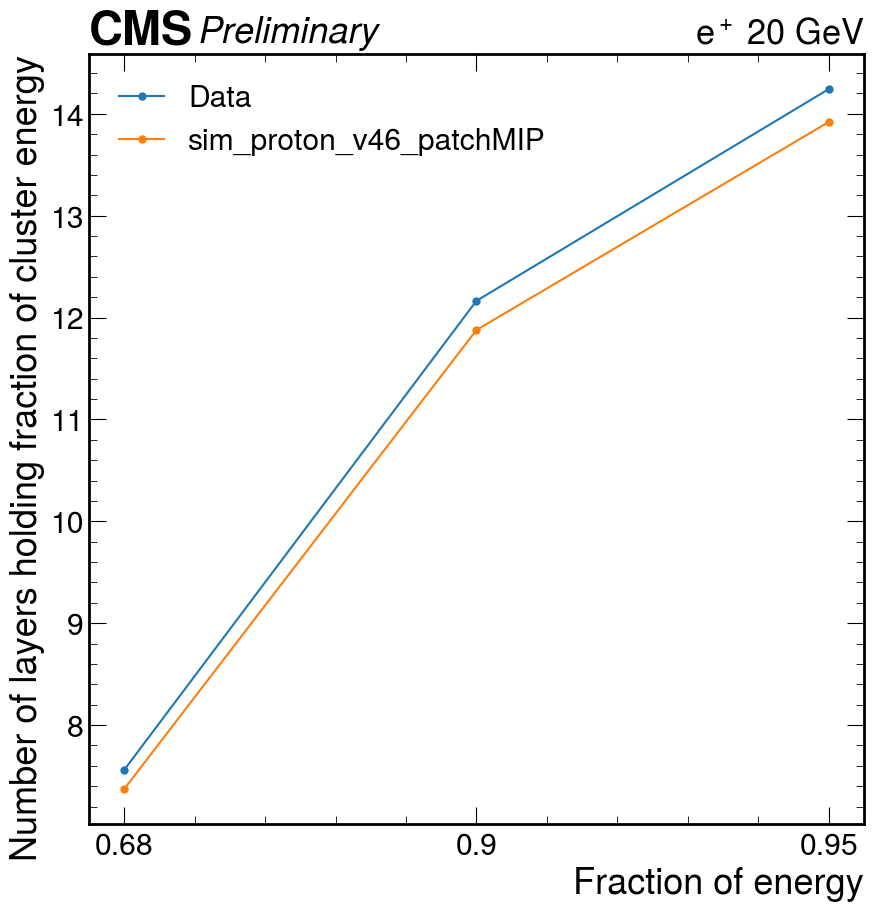

In [14]:
fig = makePlotProfile_fctFraction(20, ["data", "sim_proton_v46_patchMIP"])